## Chapter 4: Classification - Lab

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from ISLP import confusion_table, load_data
from ISLP.models import (contrast, ModelSpec as MS, summarize)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In this lab we will examine the `Smarket` data, which is part of the `ISLP` library. This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and `Direction` (whether the market was Up or Down on this date).

In [57]:
Smarket = load_data('Smarket')

In [58]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


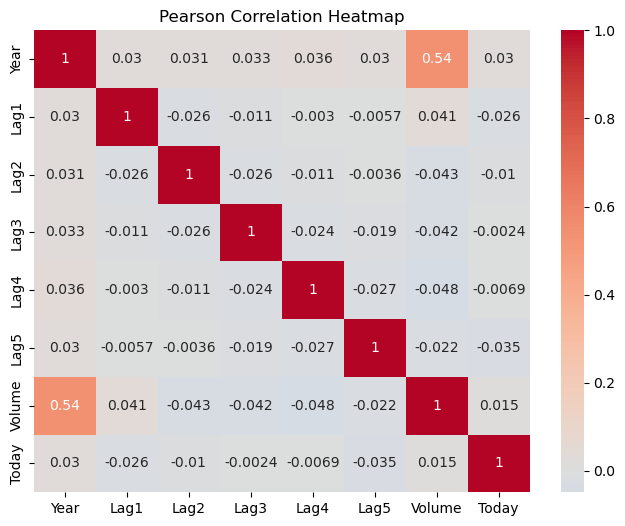

In [59]:
# Compute the Pearson correlation matrix for numerical predictors:
correlation_matrix = Smarket[Smarket.columns.drop('Direction')].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap')
plt.show()

As one would expect, the correlations between the lagged return variables and today’s return are close to zero. The only substantial correlation is between `Year` and `Volume`.

<Axes: >

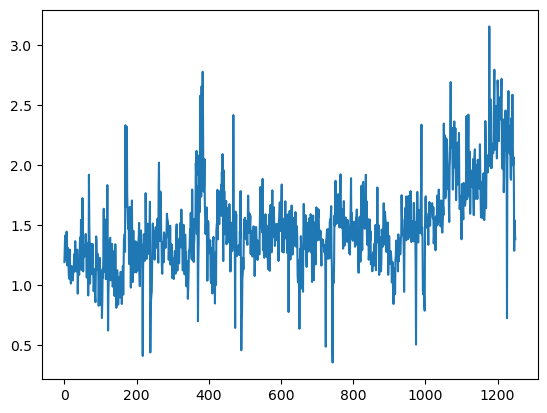

In [60]:
Smarket['Volume'].plot()

#### 4.7.2 Logistic Regression

Next, we will ft a logistic regression model in order to predict `Direction` using `Lag1` through `Lag5` and `Volume`.

The `sm.GLM()` function fits _generalized linear models_, a class of models that includes logistic regression. The syntax of `sm.GLM()` is similar to that of `sm.OLS()`, except that we must pass in the argument `family=sm.families.Binomial()` in order to tell statsmodels to run a logistic regression rather than some other type of generalized linear model.

In [61]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
# We are predicting whether Direction is Up
y = Smarket['Direction'] == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Sun, 20 Aug 2023   Deviance:                       1727.6
Time:                        07:38:27   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1260      0.241     -0.523      0.6

The smallest p-value here is associated with `Lag1`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value is still relatively large, and so there is no clear evidence of a real association between `Lag1` and `Direction`.

If no data set is supplied to the `predict()` function, then it returns the probabilities computer for the training data:

In [62]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [63]:
labels = np.array(['Down'] * 1250)
labels[probs > 0.5] = "Up"

In [64]:
print(confusion_matrix(labels, Smarket['Direction']))

[[145 141]
 [457 507]]


In [65]:
# Use the confusion_table function to display a nicer table
confusion_table(labels, Smarket['Direction'])

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [66]:
# Fraction of days on which prediction was correct
np.mean(labels == Smarket['Direction'])

0.5216

This corresponds to a training error rate of about 48%, but is probably optimistic and underestimates the test error rate.

In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model’s performance not on the data that we used to ft the model, but rather on days in the future for which the market’s movements are unknown.

To implement this strategy, we frst create a Boolean vector corresponding to the observations from 2001 through 2004. We then use this vector to create a held out data set of observations from 2005.

In [67]:
train = (Smarket['Year'] < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [68]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [69]:
# Store the test and traning labels
D = Smarket['Direction']
L_train, L_test = D.loc[train], D.loc[~train]

In [70]:
# Threhold the fitted probability at 50% to form predicted labels
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'

In [71]:
# Produce the confusion matrix of predictions and actual values for test set
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [72]:
# Produce a tuple of accuracy and error rates
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

This is worse than guessing, but one would not expect to be able to use the previous days' returns to predict future market performance.

Using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement. Below we reft the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [73]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [74]:
# Produce a tuple of accuracy and error rates
np.mean(labels == L_test), np.mean(labels != L_test)

(0.5595238095238095, 0.44047619047619047)

By removing all but `Lag1` and `Lag2`, we now seem to do a little better than chance. 

Suppose that we want to predict the returns associated with particular values of `Lag1` and `Lag2`. In particular, we want to predict probability of `Direction` = "Up" on a day when `Lag1` and `Lag2` equal 1.2 and 1.1, respectively, and on a day when they equal 1.5 and −0.8.

In [75]:
newdata = pd.DataFrame({
    'Lag1':[1.2, 1.5],
    'Lag2':[1.1, -0.8]
})

newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

#### 4.7.3 Linear Discriminant Analysis

We perform LDA on the `Smarket` data using `LinearDiscriminantAnalysis()`.

In [76]:
lda = LDA(store_covariance=True)

Since the `LDA` estimator automatically adds an intercept, we should remove the column corresponding to the intercept in both `X_train` and `X_test`.

We can also directly use the labels rather than the Boolean vectors `y_train`.

In [77]:
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

The average value of each predictor within each class suggest that there is a tendency for the previous 2 days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines:

In [78]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [79]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [80]:
lda.priors_

array([0.49198397, 0.50801603])

The linear discriminant vectors can be found in the `scalings_` attribute.

These values provide the linear combination of `Lag1` and `Lag2` that are used to form the LDA decision rule. If −0.64 × `Lag1` − 0.51 × `Lag2` is large, then the `LDA` classifer will predict a market increase, and if it is small, then the `LDA` classifer will predict a market decline.

In [81]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [82]:
lda_pred = lda.predict(X_test)

In [83]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [96]:
np.mean(lda_pred == L_test)

0.5595238095238095

Comparing confusion matrices shows that our logistic regression and LDA predictions are almost identical.

We can also estimate the probability of each class for each point in the test dataset by applying a threshold of 50% to the poterior probabilities of being in class 'Up':

In [84]:
lda_prod = lda.predict_proba(X_test)

In [85]:
# Check that probability predictions for test datapoints and in agreement with probability predictions
lda_prob = lda.predict_proba(X_test)
np.all(np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred)

True

In [86]:
# Version of the above which works with multiple classes
np.all([lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred)

True

#### 4.7.4 Quadratic Discriminant Analysis

We now fit a QDA model to the `Smarket` data.

In [87]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [88]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [90]:
qda.priors_

array([0.49198397, 0.50801603])

Unlike LDA, QDA estimates one covarance matrix per class. Here's the matrix for the first class:

In [92]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [93]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [95]:
np.mean(qda_pred == L_test)

0.5992063492063492

Interestingly, the `QDA` predictions are accurate almost 60% of the time, even though the 2005 data was not used to ft the model.

#### 4.7.5 Naive Bayes

Next, we fit a naive Bayes model to the `Smarket` data. The syntax is similar to that of `LDA()` and `QDA()`. By default, this implementation `GaussianNB()` of the naive Bayes classifer models each quantitative feature using a Gaussian
distribution.

In [98]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [99]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [102]:
# For NB, the class prior probabilities are stored in class_prior_
NB.class_prior_

array([0.49198397, 0.50801603])

The parameters of the features can be found in the `theta_` and `var_` attributes. The number of rows is equal o the number of classes, while the numer of columns is equal to the number of features.

In [106]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [107]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [108]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [111]:
# Note, we use ddof=0 here because the GaussianNB() function uses the
# population formula for variance, i.e. 1/n.
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [112]:
# Make predictions
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


Naive Bayes performs well on the data, with accurate predictions over 59% of the time, which is slightly worse than QDA, but much better than LDA.

In [114]:
np.mean(nb_labels == L_test)

0.5952380952380952

In [116]:
# Predict the probabilities of test data points belonging to each class
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

#### K-Nearest Neighbours

We perform KNN using the `KNeighborsClassifier()` function.

In [118]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn_pred = knn1.predict(X_test)
confusion_table(knn_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


The results using K = 1 are not very good: only 50% of observations are correctly predicted. K=1 might give an overly-flexible fit to the data.

In [121]:
np.mean(knn_pred == L_test)

0.5

Let's try again using K = 3:

In [122]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

The results have improved slightly. But increasing K further provides no further improvements. It appears that for these data, and this train/test split, QDA gives the best results of the methods that we have examined so far.

We try KNN on the `Caravan` dataset. This dataset includes 85
predictors that measure demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only 6% of people purchased caravan insurance.

In [123]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [124]:
Caravan.columns

Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',
       'APLEZIER', 'AFIETS',

In [125]:
feature_df = Caravan.drop(columns=['Purchase'])

Because the KNN classifer predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger effect on the distance between the observations, and hence for the KNN classifer, than variables that are on a small scale.

A good way to handle this problem is to standardize the data so that all standardize variables are given a mean of zero and a standard deviation of one. Then all variables will be on a comparable scale. This is accomplished using the `StandardScaler()` transformation.

In [126]:
# with_mean - whether or not to subtract the mean
# with_std - scale columns to have standard deviation of 1
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

In [128]:
# Fit the scaler and construct the standardised feature set
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [131]:
# Convert standardised features to DataFrame
feature_std = pd.DataFrame(X_std, columns=feature_df.columns)
feature_std.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,0.680906,-0.27258,0.406697,-1.216964,0.779405,-0.694311,0.217444,-0.068711,-0.161816,0.427670,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
1,0.992297,-0.27258,-0.859500,-1.216964,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
2,0.992297,-0.27258,-0.859500,-1.216964,0.779405,-0.694311,-0.365410,0.914172,0.464159,-1.667319,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
3,-1.187437,-0.27258,0.406697,0.010755,-0.970980,1.299414,-0.948264,0.914172,0.464159,-0.619824,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
4,1.225840,-0.27258,1.672893,-1.216964,1.479559,0.302552,-0.365410,-0.068711,0.464159,0.427670,...,-0.20291,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816


In [139]:
feature_std.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,...,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5.822000e+03,5822.000000,5.822000e+03,5.822000e+03
mean,-7.749822e-17,-1.614038e-16,-2.099164e-16,2.154084e-16,-2.929067e-17,-1.220444e-17,7.932889e-17,-1.403511e-17,9.519466e-17,-1.476738e-16,...,-4.515644e-17,2.379867e-17,1.464533e-17,9.763555e-18,-1.183831e-16,-6.102222e-19,-1.830667e-18,0.000000,3.905422e-17,3.356222e-18
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,...,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086,1.000086e+00,1.000086e+00
min,-1.810219e+00,-2.725800e-01,-2.125697e+00,-2.444683e+00,-1.671134e+00,-6.943106e-01,-2.696827e+00,-1.051594e+00,-2.039739e+00,-3.238560e+00,...,-2.029099e-01,-7.316512e-02,-8.105460e-02,-5.992001e-02,-1.014358e+00,-2.270578e-02,-7.365027e-02,-0.150620,-8.734772e-02,-1.188165e-01
25%,-1.109590e+00,-2.725800e-01,-8.595001e-01,-1.216964e+00,-9.709796e-01,-6.943106e-01,-3.654101e-01,-1.051594e+00,-7.877902e-01,-6.198244e-01,...,-2.029099e-01,-7.316512e-02,-8.105460e-02,-5.992001e-02,-1.014358e+00,-2.270578e-02,-7.365027e-02,-0.150620,-8.734772e-02,-1.188165e-01
50%,4.473633e-01,-2.725800e-01,4.066966e-01,1.075466e-02,4.293284e-01,-6.943106e-01,2.174440e-01,-6.871064e-02,-1.618158e-01,-9.607727e-02,...,-2.029099e-01,-7.316512e-02,-8.105460e-02,-5.992001e-02,7.649707e-01,-2.270578e-02,-7.365027e-02,-0.150620,-8.734772e-02,-1.188165e-01
75%,8.366015e-01,-2.725800e-01,4.066966e-01,1.075466e-02,7.794054e-01,3.025516e-01,8.002982e-01,9.141723e-01,4.641586e-01,4.276698e-01,...,-2.029099e-01,-7.316512e-02,-8.105460e-02,-5.992001e-02,7.649707e-01,-2.270578e-02,-7.365027e-02,-0.150620,-8.734772e-02,-1.188165e-01
max,1.303687e+00,2.190544e+01,2.939090e+00,3.693911e+00,1.479559e+00,8.277450e+00,2.548861e+00,3.862821e+00,3.594031e+00,1.475164e+00,...,2.098707e+01,1.366772e+01,1.233736e+01,2.578114e+01,1.144094e+01,4.404165e+01,2.442874e+01,14.069579,2.202302e+01,1.654985e+01


We use `train-test_split()` tp split observations into a test set containing 1000 observations and a training set containing the rest of the observations.

`random_state=0` ensures we get the same split each time we run the code.

In [140]:
(X_train, X_test, y_train, y_test) = train_test_split(
    feature_std,
    Purchase,
    test_size=1000,
    random_state=0
)

We fit a K = 1 KNN model on the training dataand evaluate its performance on the test data:

In [141]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

The error rate is just 11%, however since only just over 6% of customers purchased insurance, we could get the error rate down to almost 6% by predicting "No" all the time.

We see how performance varies as we vary the hyperparameter k, the number of neighbours.

In [144]:
for K in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to buy: {1:>2},' + ' # who did buy {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(K, pred, did_rent, did_rent / pred))

K=1: # predicted to buy: 62, # who did buy 9, accuracy 14.5%
K=2: # predicted to buy:  6, # who did buy 1, accuracy 16.7%
K=3: # predicted to buy: 20, # who did buy 3, accuracy 15.0%
K=4: # predicted to buy:  4, # who did buy 0, accuracy 0.0%
K=5: # predicted to buy:  7, # who did buy 1, accuracy 14.3%


#### 4.7.7 Linear and Poisson Regression on the Bikeshare Data

However, we may sometimes be faced with situations in which Y is neither qualitative nor quantitative, and so neither linear regression nor classification approaches covered in this chapter is applicable.

We fit linear and Poisson regression models to the `Bikeshare` data. The response `bikers` measures the number of bike rentals per hour in Washington DC in the period 2010-2012.

This response value is neither qualitative nor quantitative:
instead, it takes on non-negative integer values, or _counts_.

In the analyses that follow, we will treat `mnth`, `hr`, and `weathersit` as qualitative variables.

In [145]:
Bike = load_data('Bikeshare')

In [146]:
Bike.shape

(8645, 15)

In [149]:
Bike.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


first, we fit a linear regression model to the data.

In [150]:
X = MS(['mnth', 'hr', 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
M_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:30:30   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                     -27.2068      6.715     -4.052      0.000     -40.370     -14.044
mnth[Aug]                      11.8181      4.698      2.515      0.012       2.609      21.028
mnth[Dec]                       5.0328      4.280      1.176      0.240      -3.357      13.423
mnth[Feb]                     -34.5797      4.575     -7.558      0.000     -43.548     -25.611
mnth[Jan]                     -41.4249      4.972     -8.331      0.000     -51.172     -31.678
mnth[July]                      3.8996      5.003      0.779      0.436      -5.907      13.706
mnth[June]                     26.3938      4.642      5.686      0.000      17.294      35.493
mnth[March]                   -24.8735      4.277     -5.815      0.000     -33.258     -16.489
mnth[May]                      31.1322      4.150      7.501      0.000      22.997      39.268
mnth[Nov]                      18.8851      4.099      4.607      0.000      10.850      26.920
mnth[Oct]                      34.4093      4.006      8.589      0.000      26.556      42.262
mnth[Sept]                     25.2534      4.293      5.883      0.000      16.839      33.668
hr[1]                         -14.5793      5.699     -2.558      0.011     -25.750      -3.408
hr[2]                         -21.5791      5.733     -3.764      0.000     -32.817     -10.341
hr[3]                         -31.1408      5.778     -5.389      0.000     -42.468     -19.814
hr[4]                         -36.9075      5.802     -6.361      0.000     -48.281     -25.534
hr[5]                         -24.1355      5.737     -4.207      0.000     -35.381     -12.890
hr[6]                          20.5997      5.704      3.612      0.000       9.419      31.781
hr[7]                         120.0931      5.693     21.095      0.000     108.934     131.253
hr[8]                         223.6619      5.690     39.310      0.000     212.509     234.815
hr[9]                         120.5819      5.693     21.182      0.000     109.423     131.741
hr[10]                         83.8013      5.705     14.689      0.000      72.618      94.985
hr[11]                        105.4234      5.722     18.424      0.000      94.207     116.640
hr[12]                        137.2837      5.740     23.916      0.000     126.032     148.536
hr[13]                        136.0359      5.760     23.617      0.000     124.745     147.327
hr[14]                        126.6361      5.776     21.923      0.000     115.313     137.959
hr[15]                        132.0865      5.780     22.852      0.000     120.756     143.417
hr[16]                        178.5206      5.772     30.927      0.000     167.206     189.836
hr[17]                        296.2670      5.749     51.537      0.000     284.998     307.536
hr[18]     

In `M_lm`, the first levels `hr[0]` and `mnth[Jan]` are treated as the baseline values, and so no coefcient estimates are provided for them: implicitly, their coefficient estimates are zero, and all other levels are measured relative to these baselines. For example, the Feb coefficient of 6.845 signifies that, holding all other variables constant, there are on average about 7 more riders in February than in January

We can use an alternative encoding in which the (unreported) coefficient for the last month is set to the negative of the sum of the coefficient estimates for all other levels.

In this way, the coefficients will always sum to zero, and each coefficient can be interpreted as the difference from the mean level.

In [152]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [158]:
X2 = MS([mnth_encode, hr_encode, 'workingday', 'temp','weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


We can produce plots of the coefficient values for Month and Hour:

In [157]:
S2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:38:58   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                      73.5974      5.132     14.340      0.000      63.537      83.658
mnth[Jan]                     -46.0871      4.085    -11.281      0.000     -54.096     -38.079
mnth[Feb]                     -39.2419      3.539    -11.088      0.000     -46.179     -32.304
mnth[March]                   -29.5357      3.155     -9.361      0.000     -35.721     -23.351
mnth[April]                    -4.6622      2.741     -1.701      0.089     -10.034       0.710
mnth[May]                      26.4700      2.851      9.285      0.000      20.882      32.058
mnth[June]                     21.7317      3.465      6.272      0.000      14.939      28.524
mnth[July]                     -0.7626      3.908     -0.195      0.845      -8.424       6.899
mnth[Aug]                       7.1560      3.535      2.024      0.043       0.227      14.085
mnth[Sept]                     20.5912      3.046      6.761      0.000      14.621      26.561
mnth[Oct]                      29.7472      2.700     11.019      0.000      24.455      35.039
mnth[Nov]                      14.2229      2.860      4.972      0.000       8.616      19.830
hr[0]                         -96.1420      3.955    -24.307      0.000    -103.895     -88.389
hr[1]                        -110.7213      3.966    -27.916      0.000    -118.496    -102.947
hr[2]                        -117.7212      4.016    -29.310      0.000    -125.594    -109.848
hr[3]                        -127.2828      4.081    -31.191      0.000    -135.282    -119.283
hr[4]                        -133.0495      4.117    -32.319      0.000    -141.119    -124.980
hr[5]                        -120.2775      4.037    -29.794      0.000    -128.191    -112.364
hr[6]                         -75.5424      3.992    -18.925      0.000     -83.367     -67.718
hr[7]                          23.9511      3.969      6.035      0.000      16.172      31.730
hr[8]                         127.5199      3.950     32.284      0.000     119.777     135.263
hr[9]                          24.4399      3.936      6.209      0.000      16.724      32.155
hr[10]                        -12.3407      3.936     -3.135      0.002     -20.056      -4.625
hr[11]                          9.2814      3.945      2.353      0.019       1.549      17.014
hr[12]                         41.1417      3.957     10.397      0.000      33.385      48.899
hr[13]                         39.8939      3.975     10.036      0.000      32.102      47.686
hr[14]                         30.4940      3.991      7.641      0.000      22.671      38.317
hr[15]                         35.9445      3.995      8.998      0.000      28.114      43.775
hr[16]                         82.3786      3.988     20.655      0.000      74.561      90.197
hr[17]     

In [159]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
months = Bike['mnth'].dtype.categories
# Append Dec as the negative sum of the other months
coef_month = pd.concat([
    coef_month, 
    pd.Series([-coef_month.sum()], index=['mnth[Dec]'])
])

coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

Text(0, 0.5, 'Coefficient')

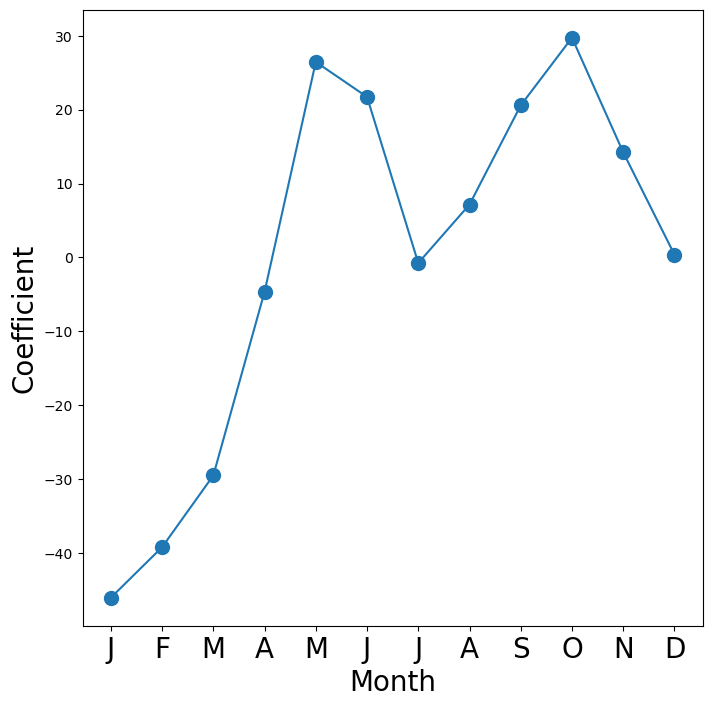

In [161]:
fig_month, ax_month = plt.subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)

In [162]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([
    coef_hr, 
    pd.Series([-coef_hr.sum()], index=['hr[23]'])
])

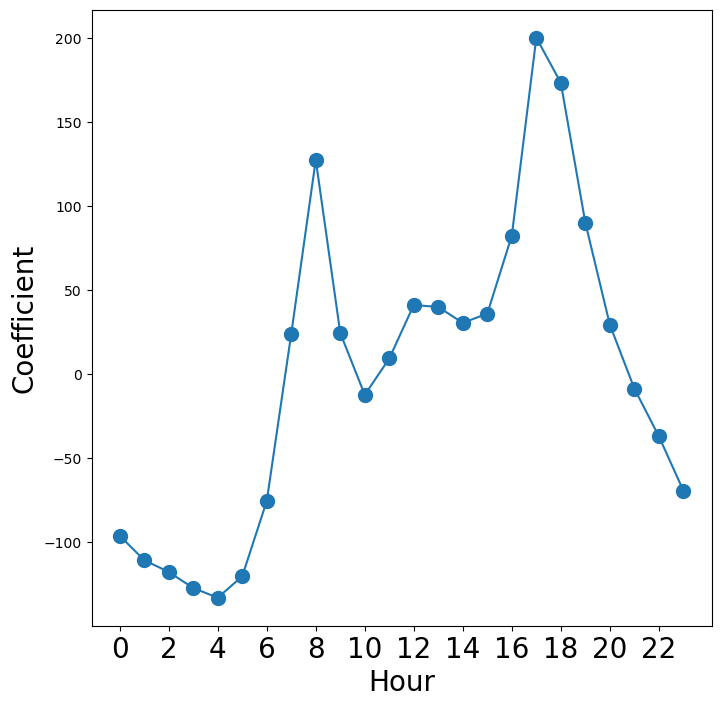

In [164]:
fig_hr, ax_hr = plt.subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20)

We now instead fit a Poisson regression model to the `Bikeshare` data. We use `sm.GLM()` with the "Poisson" family specified:

In [165]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

We can produce the same plot of the coefficients associated with each month and hour as before:

In [166]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([
    coef_month,
    pd.Series(
        [-coef_month.sum()],
        index=['mnth[Dec]']
    )
])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([
    coef_hr,
    pd.Series([-coef_hr.sum()], index=['hr[23]'])
])

C:\Users\rich\AppData\Local\Temp\ipykernel_21608\2045127785.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_hr.set_xticklabels(range(24)[::2], fontsize=20)


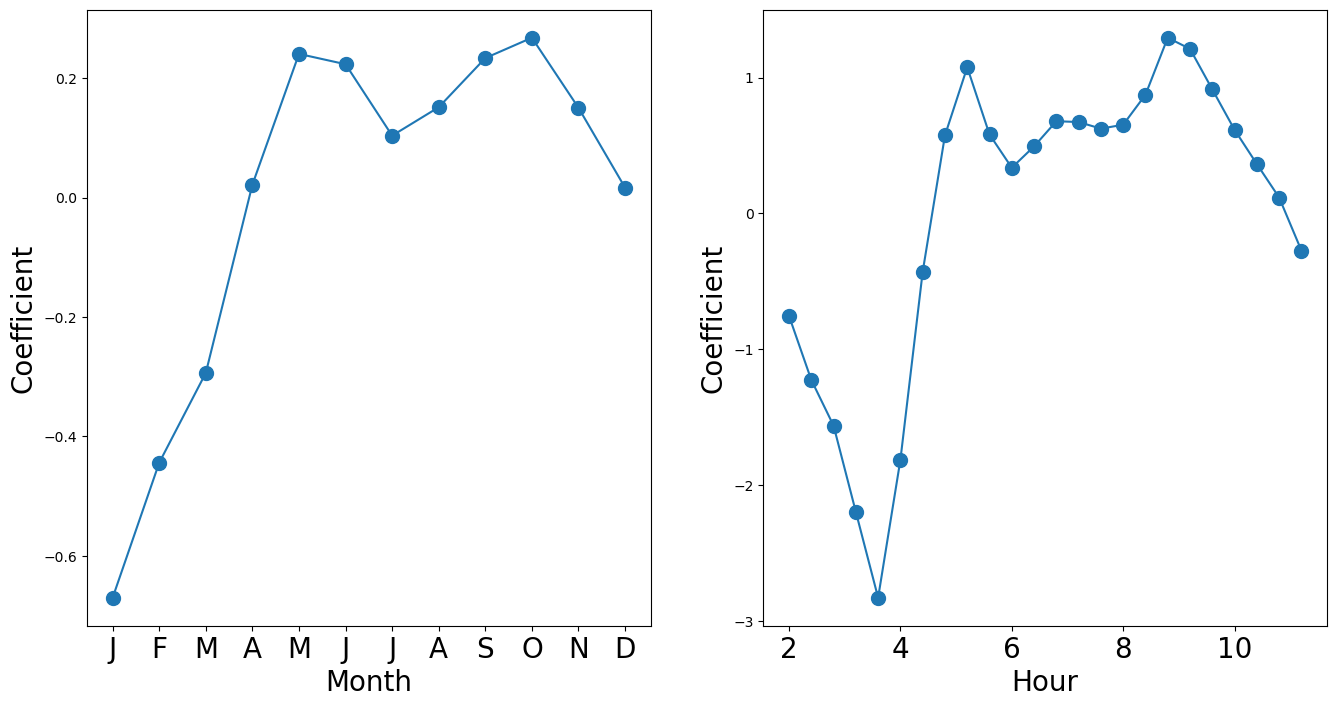

In [167]:
fig_pois, (ax_month, ax_hr) = plt.subplots(1, 2, figsize=(16,8))
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20)

In [ ]:
We compare the ftted values of the two models. The fitted values are stored
in the `fittedvalues` attribute returned by the `fit()` method for each of the fits. 

The linear predictors are stored as the `lin_pred` attribute.

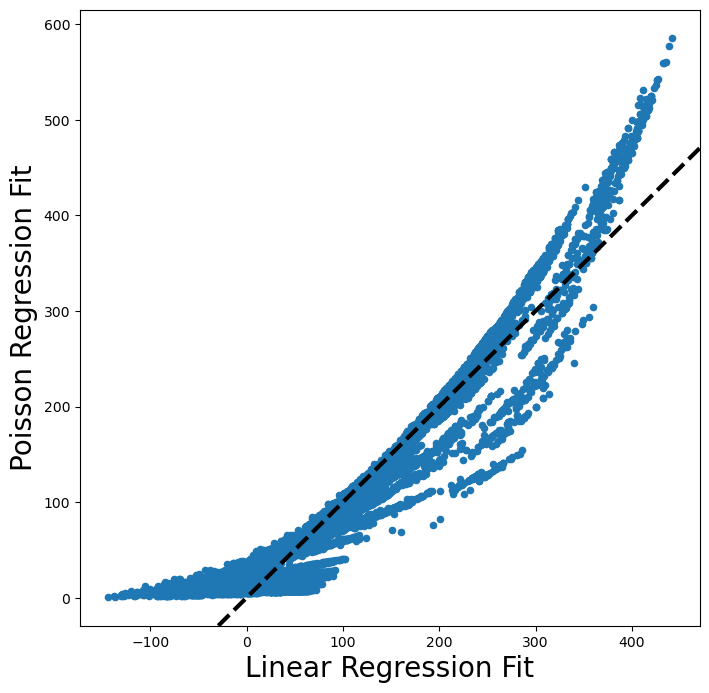

In [169]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues, M_pois.fittedvalues, s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3, linestyle='--', slope=1)